In [1]:
import sys
sys.path.append('..')

In [1]:
from copy import deepcopy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.integrate as integrate
from time import time
import pandas as pd
import json
import pdb

import mplhep as hep
plt.style.use(hep.styles.CMS)
from matplotlib.backends.backend_pdf import PdfPages

from symfit import Fit
from symfit.core.objectives import LogLikelihood
from symfit.core.minimizers import  BasinHopping, SLSQP
import sympy

import sys
sys.path.append('/home/horacio/Documents/hcl/')
import completeSymfit as Complete

import os
from copy import deepcopy
from random import random


In [3]:
bin_ = 0

In [4]:
data_dir = '/home/horacio/Documents/hcl/DataSelection/Data/AntiRad_Resonance/'
dataDF = pd.read_pickle(data_dir+f'df_Bin{bin_}OnlyResonanceRej.pkl')
antiRad_JP_1 = (np.abs((dataDF.BMass - 5.27934)- (dataDF.DiMuMass-3.0969)) > 0.130) | (dataDF.DiMuMass>3.0969)
antiRad_JP_2 = ((np.abs((dataDF.BMass - 5.27934)- (dataDF.DiMuMass-3.0969)) > 0.127) | (dataDF.DiMuMass > 3.35))  | (dataDF.DiMuMass<3.0969)
antiRad_PP_1 = (np.abs((dataDF.BMass - 5.27934)- (dataDF.DiMuMass-3.6861)) > 0.085) | (dataDF.DiMuMass>3.6861)
antiRad_PP_2 = ((np.abs((dataDF.BMass - 5.27934)- (dataDF.DiMuMass-3.6861)) > 0.054) | (dataDF.DiMuMass > 3.92))  | (dataDF.DiMuMass<3.6861)
dataDF = dataDF[antiRad_JP_1 & antiRad_JP_2 &antiRad_PP_1 &antiRad_PP_2]
dataDF = dataDF[(dataDF.R_XGB>0.96) & (dataDF.L_XGB>0.98)]
dataDF = dataDF[(dataDF.BMass>5) & (dataDF.BMass<5.7)]

In [5]:
dataDF.keys()

Index(['Bpt', 'kpt', 'PDL', 'prob', 'cosA', 'signLxy', 'BMass', 'DiMuMass',
       'cosThetaKMu', 'R_XGB', 'L_XGB'],
      dtype='object')

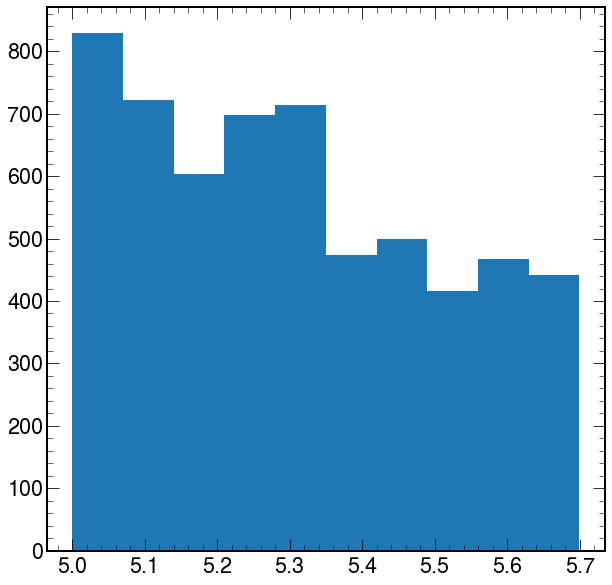

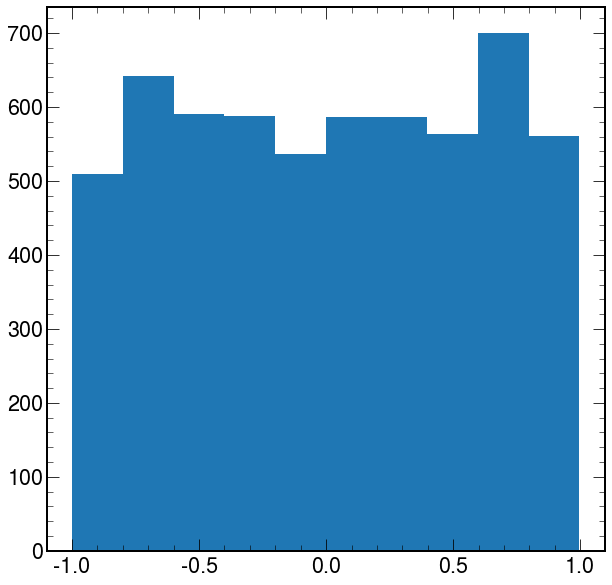

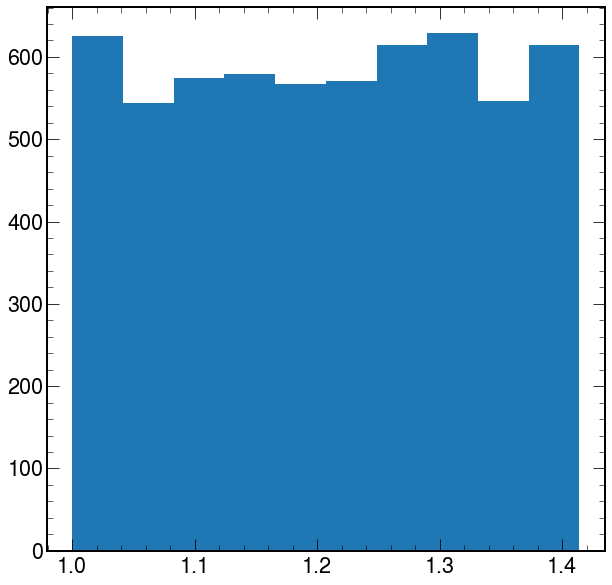

In [6]:
plt.hist(dataDF.BMass)
plt.show()

plt.hist(dataDF.cosThetaKMu)
plt.show()

plt.hist(dataDF.DiMuMass)
plt.show()

In [7]:
parameter_path = f'/home/horacio/Documents/hcl/Experiments_Fitting/CompleteFit/Symfit/Params/Bin{bin_}.json'
with open(parameter_path) as file:
    parameters = json.load(file)

In [8]:
parameters

{'Signal': {'yield': 538.0,
  'mass': {'2Gaussian+CrystalBall': {'muCB': 5.280500506948775,
    'alphaCB': -5.3022425168550456,
    'sigmaCB': 0.03092999416324259,
    'nCB': 3.0438535136416878,
    'muGauss': 5.278494851564458,
    'sigmaGauss1': 0.05835146361679967,
    'sigmaGauss2': 0.10102419078624053,
    'fracCB': 0.49641896946768643,
    'fracGauss1': 0.35188002124745454,
    'fracGauss2': 0.1199130312811354}},
  'angle': {'AFB': 0,
   'FH': 0.2,
   'Chi2EffyCoefs': [1, 0.098, -1.0869, 0.012, -0.1788, 0.069]}},
 'Background': {'yield': 5326.0,
  'mass': {'Exponential+Gauss': {'mu': 4.973826395867015,
    'sigma': 0.11840086441328829,
    'lambda_': -0.11118976231969459,
    'fraction_exp': 0.8638028934575626}},
  'angle': {'2SideBands': {'Left': {'mu': 0,
     'sigma': 0.1,
     'fraction_Cheby': 1,
     'coefs': [1,
      0.08718022074688103,
      -0.2498755711090439,
      0.0071827404755375746,
      -0.10486673877605102]},
    'Right': {'mu': 0,
     'sigma': 0.1,
     'fr

In [9]:
parameters['Signal']['angle']['coefsEff'] = parameters['Signal']['angle']['Chi2EffyCoefs'] 

In [10]:
def create_models(afb, fh, bin_data) :   

    free = {'Signal:angle:AFB':[afb,-1.5,1.5], 'Signal:angle:FH':[fh,0,3],
        'Background:angle:2SideBands:fraction_Left':[0.5, 0, 1]}
    print(free)
    model = Complete.complete_v1(bin_, params = parameters, free_Params = free)
    
    AFB, FH = model.symParams('AFB'), model.symParams('FH')
    _constraints = [
                sympy.LessThan(FH, 3),
                sympy.GreaterThan(FH, 0),
                sympy.LessThan(sympy.Abs(AFB), 0.5*FH)
                ]


    fitConstraintSLSQP = Fit(model.pdf, 
                                cos=np.array(bin_data.cosThetaKMu), 
                                mass=np.array(bin_data.BMass), 
                                objective=LogLikelihood, 
                                constraints=_constraints,
                                minimizer=SLSQP)


    fitConstraintBH_SLSQP = Fit(model.pdf, 
                                cos=np.array(bin_data.cosThetaKMu), 
                                mass=np.array(bin_data.BMass), 
                                objective=LogLikelihood, 
                                constraints=_constraints,
                                minimizer=[BasinHopping, SLSQP])
    
    return fitConstraintSLSQP, fitConstraintBH_SLSQP, model


In [14]:
def update_to_save(result, diction, model, j):
    for k in result.params:
        
        if not k+str(j) in diction: diction[k+str(j)]=list()
        if not 'err'+k+str(j) in diction: diction['err'+k+str(j)]=list()
            
        diction[k+str(j)].append(result.params[k])
        diction['err'+k+str(j)].append(result.stdev(model.symParams(k)))
    
    if not 'Status'+str(j) in diction:   diction['Status'+str(j)]=list()
    diction['Status'+str(j)].append(result.status_message)
        
    if not 'NLL'+str(j) in diction:   diction['NLL'+str(j)]=list()
    diction['NLL'+str(j)].append(result.minimizer_output['fun'])


In [15]:
fitConstraintSLSQP, fitConstraintBH_SLSQP, model = create_models(0.1, 0.2, dataDF)

{'Signal:angle:AFB': [0.1, -1.5, 1.5], 'Signal:angle:FH': [0.2, 0, 3], 'Background:angle:2SideBands:fraction_Left': [0.5, 0, 1]}
5.30224251685505 [5, 5.7]
[5, 5.7] mass
couldn't reduce degree in a polynomial division algorithm when dividing [-1.02369373752892e-105*_u**4 - 2.46555473488372e-90*_u**2 - 1.99997283280396e-75*_u, 0.0] by [-3.33256003586195e-176*_u**9 - 4.81585978763786e-160*_u**7 + 3.90645910455644e-145*_u**6 - 1.73984153658231e-144*_u**5 + 9.40866236528743e-130*_u**4 + 1.90799547636967e-114*_u**3 + 3.67630833984043e-99*_u + 1.98806288923271e-84]. This can happen when it's not possible to detect zero in the coefficient domain. The domain of computation is RR[_u]. Zero detection is guaranteed in this coefficient domain. This may indicate a bug in SymPy or the domain is user defined and doesn't implement zero detection properly.
falling back to numeric integration
0.0775300001937762
algo
5.30224251685505 [5, 5.7]
[5, 5.7] mass
couldn't reduce degree in a polynomial division a

In [16]:
fitmass = Fit(model.projection_mass, 
            mass=np.array(dataDF.BMass), 
            objective=LogLikelihood, 
            minimizer=SLSQP)

In [17]:
res_mass = fitmass.execute()

/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/fit_results.py:254: RuntimeWarning: overflow encountered in exp
  gof_qualifiers['likelihood'] = np.exp(gof_qualifiers['log_likelihood'])


In [31]:
538/(5326+538)

0.0917462482946794

In [18]:
print(res_mass)


Parameter Value        Standard Deviation
Frac      9.153001e-02 7.807524e-03
Status message         Optimization terminated successfully.
Number of iterations   6
Objective              <symfit.core.objectives.LogLikelihood object at 0x7f7cea6d29e8>
Minimizer              <symfit.core.minimizers.SLSQP object at 0x7f7cea6d2710>

Goodness of fit qualifiers:
likelihood             inf
log_likelihood         2262.18310546875
objective_value        -2262.18310546875


In [19]:
model.symParams('AFB')

AFB

In [29]:
model.projection_mass

Frac*(6.61314602958555*Piecewise((3.11119696405456e-14/(1 - 0.194779810842708*mass)**3, 32.3310762595748*mass - 170.724264578884 <= -5.30224251685505), (exp(-14573.3872580004*(0.189375987879192*mass - 1)**2), True)) + 2.48475083580133*exp(-4091.53905748995*(0.189447944560108*mass - 1)**2) + 0.490520133422459*exp(-1365.02136264232*(0.189447944560108*mass - 1)**2)) + (1 - Frac)*(1.11243525033821*exp(-882.351246937618*(0.201052453465394*mass - 1)**2) + 2.23642162958293*exp(-0.111189762319695*mass))

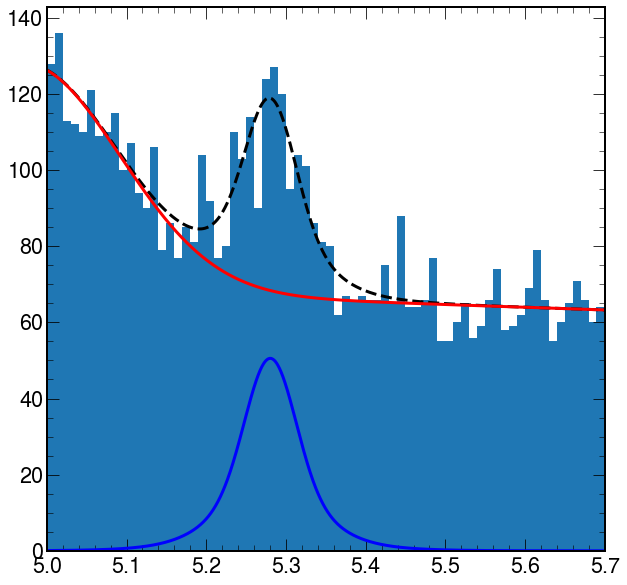

In [72]:
m = np.linspace(5, 5.7, 1400)
h = plt.hist(dataDF.BMass, bins=70)
scale = np.sum(h[0])*(h[1][1]-h[1][0])
plt.plot(m , scale*model.projection_mass(m, Frac=0.09), color='black', ls='--', linewidth=3)
plt.plot(m , scale*model.mass_signal(m, Frac=0.09), color='blue', linewidth=3)
plt.plot(m , scale*model.mass_background(m, Frac=0.09), color='red', linewidth=3)
plt.xlim(5, 5.7)
plt.show()

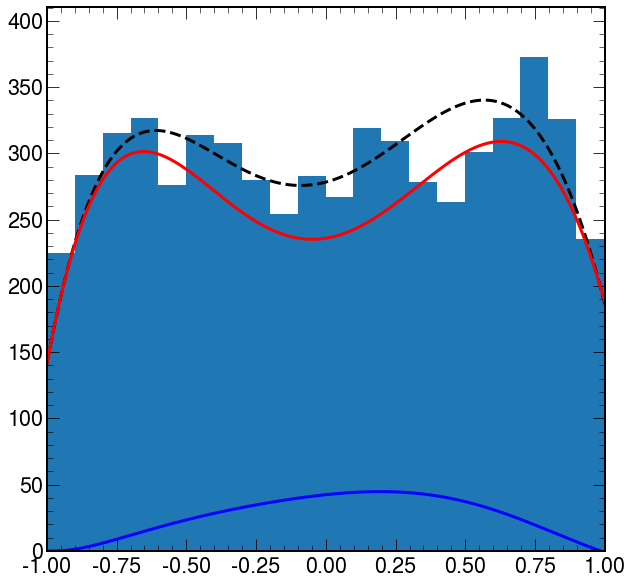

In [70]:
t = np.linspace(-1, 1, 1000)
h = plt.hist(dataDF.cosThetaKMu, bins=20)
scale = np.sum(h[0])*(h[1][1]-h[1][0])
plt.plot(t , scale*model.projection_angular(t, Frac=0.09, AFB=0.2, FH=0.4, fraction_Left=0.5), color='black', ls='--', linewidth=3)
plt.plot(t , scale*model.angular_back(t, Frac=0.09, AFB=0.2, FH=0.4, fraction_Left=0.5), color='red', linewidth=3)
plt.plot(t , scale*model.angular_signal(t, Frac=0.09, AFB=0.2, FH=0.4, fraction_Left=1), color='blue', linewidth=3)
plt.ylim(0, max(h[0])*1.1)
plt.xlim(-1, 1)
plt.show()

In [21]:
data_bin4

,DiMuMass,Bmass,DiMupt,l1pt,l2pt,Mu1_isSoft,Mu2_isSoft,k_HighPurity,k_numberOfPixelHits,k_nValidHits,Bpt,kpt,PDL,prob,cosA,signLxy,cos_l,XGB
6055,3.244617,5.246500,76.290016,50.694317,25.660975,1,1,1,4,18.0,134.975525,58.685520,0.025794,0.888645,0.999998,46.705223,-0.197187,0.994157
23413,3.533545,5.277145,19.815823,15.703088,4.366426,1,0,1,4,15.0,24.033531,4.266780,0.112206,0.083665,0.999993,89.226013,-0.370091,0.989754
27054,3.401248,5.371689,15.035718,10.416736,4.889770,1,0,1,4,15.0,29.809763,14.796907,0.066586,0.584345,0.999839,34.317047,0.078484,0.968479
28008,3.549512,5.535728,13.067906,9.415505,3.691065,1,1,1,4,19.0,20.646832,7.583993,0.050338,0.047877,0.999866,34.571236,0.745750,0.968848
32950,3.310476,5.338144,36.277218,25.817999,10.608738,0,1,1,4,19.0,85.118248,48.841362,0.054294,0.457064,1.000000,88.931122,-0.173849,0.991000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547658,3.237659,5.119992,49.688583,25.520906,24.249924,1,1,1,0,16.0,51.013027,1.373148,0.127573,0.866065,0.999997,72.681564,0.174208,0.974839
2552398,3.560202,5.347310,27.723495,16.799452,10.954262,0,1,1,4,17.0,35.617126,8.046929,0.032124,0.251723,0.999999,28.637573,-0.296804,0.991859
2552909,3.213202,5.164570,19.506262,15.076797,4.651718,1,1,1,4,17.0,32.361965,12.976322,0.063957,0.444469,0.999987,56.838806,-0.686521,0.985962
2553434,3.298210,5.287494,13.346449,9.520180,4.204756,1,1,1,4,17.0,26.056480,12.712041,0.046579,0.171179,0.999993,36.364079,-0.409584,0.989171


In [20]:
resultSLSQP = fitConstraintSLSQP.execute()

/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/objectives.py:520: RuntimeWarning: overflow encountered in square
  (1 / f**2)[np.newaxis, np.newaxis, ...] * jac_outer_jac
/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/objectives.py:520: RuntimeWarning: invalid value encountered in multiply
  (1 / f**2)[np.newaxis, np.newaxis, ...] * jac_outer_jac


In [21]:
print(resultSLSQP)


Parameter Value        Standard Deviation
AFB       1.000000e-01 None
FH        2.000000e-01 None
Frac      0.000000e+00 None
fraction_Left5.756602e-01 None
Status message         Optimization terminated successfully.
Number of iterations   5
Objective              <symfit.core.objectives.LogLikelihood object at 0x7f7ced6dc128>
Minimizer              <symfit.core.minimizers.SLSQP object at 0x7f7ced6dcd30>

Goodness of fit qualifiers:
likelihood             inf
log_likelihood         3288350.666847966
objective_value        -3288350.666847966

Constraints:
--------------------
Question: 3 - FH >= 0?
Answer:   2.7999999999989065

Question: FH >= 0?
Answer:   0.20000000000109366

Question: 0.5*FH - Abs(AFB) >= 0?
Answer:   2.7341046093809496e-12




In [24]:
afb_ini = [0.1063] 
fh_ini = [1.799]
for i in range(20):
    line=' - '+str(i)
    line*=15
    print('\n\n'+line)
    model = modelsSymfit.complete(4, afb_ini[-1] , fh_ini[-1], 
                                  params = Params)
    _constraints = [
            sympy.LessThan(model.FH, 3),
            sympy.GreaterThan(model.FH, 0),
            sympy.LessThan(sympy.Abs(model.AFB), 0.5*model.FH)
            ]
    fitConstraintSLSQP = Fit(model.pdf, 
                            cos=np.array(data_bin4.cos_l), 
                            mass=np.array(data_bin4.Bmass), 
                            objective=LogLikelihood, 
                            constraints=_constraints,
                            #minimizer=[SLSQP, BasinHopping])
                            minimizer=SLSQP)
    resultSLSQP = fitConstraintSLSQP.execute()
    print(resultSLSQP)
    if np.abs(resultSLSQP.params['AFB'])<0.5*resultSLSQP.params['FH']:
        afb_ini.append(resultSLSQP.params['AFB'])
    else:
        sign = resultSLSQP.params['AFB']/np.abs(resultSLSQP.params['AFB'])
        afb_ini.append(sign*resultSLSQP.params['FH']/2)
    fh_ini.append(resultSLSQP.params['FH'])



 - 0 - 0 - 0 - 0 - 0 - 0 - 0 - 0 - 0 - 0 - 0 - 0 - 0 - 0 - 0


/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/objectives.py:462: RuntimeWarning: invalid value encountered in log
  [np.nansum(np.log(component)) for component in evaluated_func]



Parameter Value        Standard Deviation
AFB       -1.622684e-01 2.216167e-02
FH        5.980000e-01 6.162368e-02
FRAC      2.105489e-01 8.269743e-03
LAMBDA    -3.304228e+00 5.571542e-02
MU        5.269719e+00 1.802423e-03
SIGMA     5.067611e-02 2.043685e-03
Status message         Optimization terminated successfully.
Number of iterations   20
Objective              <symfit.core.objectives.LogLikelihood object at 0x7fb1684a7f28>
Minimizer              <symfit.core.minimizers.SLSQP object at 0x7fb1684359b0>

Goodness of fit qualifiers:
likelihood             0.0
log_likelihood         -1371.4151611328125
objective_value        1371.4151611328125

Constraints:
--------------------
Question: 3 - FH >= 0?
Answer:   2.402

Question: FH >= 0?
Answer:   0.5979999999999999

Question: 0.5*FH - Abs(AFB) >= 0?
Answer:   0.13673158777039882




 - 1 - 1 - 1 - 1 - 1 - 1 - 1 - 1 - 1 - 1 - 1 - 1 - 1 - 1 - 1


KeyboardInterrupt: 

In [41]:
resultSLSQP.minimizer_output

{'x': array([-0.16226841,  0.598     ,  0.21054887, -3.30422792,  5.26971941,
         0.05067611]),
 'fun': 1371.4151611328125,
 'jac': array([-1.22089386e-02,  2.54289154e+02,  2.74353027e-02, -1.08804703e-02,
         1.34889603e-01, -1.68273926e-01]),
 'nit': 20,
 'nfev': 52,
 'njev': 19,
 'status': 0,
 'success': True}

In [250]:
model = modelsSymfit.complete(4, 0, 0, params = Params)
_constraints = [
            sympy.LessThan(model.FH, 3),
            sympy.GreaterThan(model.FH, 0),
            sympy.LessThan(sympy.Abs(model.AFB), 0.5*model.FH)
            ]


In [251]:
_constraints = [
            sympy.LessThan(model.FH, 3),
            sympy.GreaterThan(model.FH, 0),
            sympy.LessThan(sympy.Abs(model.AFB), 0.5*model.FH)
            ]
    
fitConstraintSLSQP = Fit(model.pdf, 
                            cos=np.array(data_bin4.cos_l), 
                            mass=np.array(data_bin4.Bmass), 
                            objective=LogLikelihood, 
                            constraints=_constraints,
                            #minimizer=[SLSQP, BasinHopping])
                            minimizer=SLSQP)

fitConstraintSLSQP_BH = Fit(model.pdf, 
                            cos=np.array(data_bin4.cos_l), 
                            mass=np.array(data_bin4.Bmass), 
                            objective=LogLikelihood, 
                            constraints=_constraints,
                            minimizer=[SLSQP, BasinHopping])
                            #minimizer=SLSQP)

fitConstraintBH_SLSQP = Fit(model.pdf, 
                            cos=np.array(data_bin4.cos_l), 
                            mass=np.array(data_bin4.Bmass), 
                            objective=LogLikelihood, 
                            constraints=_constraints,
                            minimizer=[BasinHopping, SLSQP])

fitConstraintBH = Fit(model.pdf, 
                            cos=np.array(data_bin4.cos_l), 
                            mass=np.array(data_bin4.Bmass), 
                            objective=LogLikelihood, 
                            constraints=_constraints,
                            minimizer=BasinHopping )

In [252]:
resultSLSQP = fitConstraintSLSQP.execute()

In [267]:
resultSLSQP.stdev(model.AFB)

0.01582137183853072

In [271]:
model.symParams()

{'AFB': AFB,
 'FH': FH,
 'LAMBDA': LAMBDA,
 'MU': MU,
 'SIGMA': SIGMA,
 'FRAC': FRAC}

In [240]:
print(resultSLSQP)


Parameter Value        Standard Deviation
AFB       -4.554837e-02 1.668164e-02
FH        9.109674e-02 4.219299e-02
FRAC      2.187237e-01 7.780030e-03
LAMBDA    -3.313240e+00 5.594752e-02
MU        5.269108e+00 1.771252e-03
SIGMA     5.183258e-02 2.011450e-03
Status message         Optimization terminated successfully.
Number of iterations   17
Objective              <symfit.core.objectives.LogLikelihood object at 0x7f0d1b331a20>
Minimizer              <symfit.core.minimizers.SLSQP object at 0x7f0d1b331860>

Goodness of fit qualifiers:
likelihood             0.0
log_likelihood         -1290.58740234375
objective_value        1290.58740234375

Constraints:
--------------------
Question: 3 - FH >= 0?
Answer:   2.9089032604277865

Question: FH >= 0?
Answer:   0.09109673957221347

Question: 0.5*FH - Abs(AFB) >= 0?
Answer:   8.580960386694869e-10




In [241]:
resultSLSQP_BH = fitConstraintSLSQP_BH.execute()

/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/objectives.py:462: RuntimeWarning: invalid value encountered in log
  [np.nansum(np.log(component)) for component in evaluated_func]


KeyboardInterrupt: 

In [254]:
resultBH_SLSQP = fitConstraintBH_SLSQP.execute()

In [255]:
print(resultBH_SLSQP)


Parameter Value        Standard Deviation
AFB       0.000000e+00 1.585367e-02
FH        0.000000e+00 4.014454e-02
FRAC      2.150755e-01 7.805807e-03
LAMBDA    -3.306410e+00 5.574947e-02
MU        5.269050e+00 1.764421e-03
SIGMA     5.127519e-02 2.006160e-03
Status message         Optimization terminated successfully.
Number of iterations   101
Objective              <symfit.core.objectives.LogLikelihood object at 0x7f0d1b1c71d0>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.BasinHopping object at 0x7f0d1b15cf98>, <symfit.core.minimizers.SLSQP object at 0x7f0d1b15c630>])

Goodness of fit qualifiers:
likelihood             0.0
log_likelihood         -1295.5013427734375
objective_value        1295.5013427734375

Constraints:
--------------------
Question: 3 - FH >= 0?
Answer:   3.0

Question: FH >= 0?
Answer:   0.0

Question: 0.5*FH - Abs(AFB) >= 0?
Answer:   0.0




In [245]:
print(resultBH_SLSQP)


Parameter Value        Standard Deviation
AFB       -4.554019e-02 1.668384e-02
FH        9.108038e-02 4.219826e-02
FRAC      2.186478e-01 7.777916e-03
LAMBDA    -3.314386e+00 5.595312e-02
MU        5.269120e+00 1.770679e-03
SIGMA     5.180911e-02 2.010396e-03
Status message         Optimization terminated successfully.
Number of iterations   128
Objective              <symfit.core.objectives.LogLikelihood object at 0x7f0d1b24a908>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.BasinHopping object at 0x7f0d1b5c7978>, <symfit.core.minimizers.SLSQP object at 0x7f0d1b242c18>])

Goodness of fit qualifiers:
likelihood             0.0
log_likelihood         -1290.586181640625
objective_value        1290.586181640625

Constraints:
--------------------
Question: 3 - FH >= 0?
Answer:   2.9089196209870702

Question: FH >= 0?
Answer:   0.09108037901292983

Question: 0.5*FH - Abs(AFB) >= 0?
Answer:   -8.572570431297777e-11




In [243]:
print(resultBH_SLSQP)


Parameter Value        Standard Deviation
AFB       -4.590377e-02 1.669444e-02
FH        9.180700e-02 4.222799e-02
FRAC      2.186833e-01 7.780913e-03
LAMBDA    -3.312958e+00 5.594319e-02
MU        5.268981e+00 1.772377e-03
SIGMA     5.183585e-02 2.012493e-03
Status message         Iteration limit exceeded
Number of iterations   201
Objective              <symfit.core.objectives.LogLikelihood object at 0x7f0d1b24a908>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.BasinHopping object at 0x7f0d1b5c7978>, <symfit.core.minimizers.SLSQP object at 0x7f0d1b242c18>])

Goodness of fit qualifiers:
likelihood             0.0
log_likelihood         -1290.5889892578125
objective_value        1290.5889892578125

Constraints:
--------------------
Question: 3 - FH >= 0?
Answer:   2.9081929974567062

Question: FH >= 0?
Answer:   0.09180700254329358

Question: 0.5*FH - Abs(AFB) >= 0?
Answer:   -2.7057229062127375e-07




In [191]:
print(resultBH_SLSQP)


Parameter Value        Standard Deviation
AFB       0.000000e+00 None
FH        0.000000e+00 None
FRAC      0.000000e+00 None
LAMBDA    -4.000000e+00 None
MU        5.400000e+00 None
SIGMA     1.000000e-01 None
Status message         Optimization terminated successfully.
Number of iterations   101
Objective              <symfit.core.objectives.LogLikelihood object at 0x7f0d4a82feb8>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.BasinHopping object at 0x7f0d4a82fe48>, <symfit.core.minimizers.SLSQP object at 0x7f0d4a82fdd8>])

Goodness of fit qualifiers:
likelihood             inf
log_likelihood         36878.60546875
objective_value        -36878.60546875

Constraints:
--------------------
Question: 3 - FH >= 0?
Answer:   3.0

Question: FH >= 0?
Answer:   0.0

Question: 0.5*FH - Abs(AFB) >= 0?
Answer:   0.0




In [187]:
print(resultBH_SLSQP)


Parameter Value        Standard Deviation
AFB       -7.750000e-02 None
FH        5.000000e-01 None
FRAC      0.000000e+00 None
LAMBDA    -4.000000e+00 None
MU        5.200000e+00 None
SIGMA     1.000000e-01 None
Status message         Optimization terminated successfully.
Number of iterations   105
Objective              <symfit.core.objectives.LogLikelihood object at 0x7f0d4a8d6710>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.BasinHopping object at 0x7f0d4a8d66a0>, <symfit.core.minimizers.SLSQP object at 0x7f0d4a8d6828>])

Goodness of fit qualifiers:
likelihood             inf
log_likelihood         36878.60546875
objective_value        -36878.60546875

Constraints:
--------------------
Question: 3 - FH >= 0?
Answer:   2.5

Question: FH >= 0?
Answer:   0.5

Question: 0.5*FH - Abs(AFB) >= 0?
Answer:   0.1725




In [138]:
resultSLSQP_BH.params

OrderedDict([('AFB', -0.07750000000000001),
             ('FH', 0.5),
             ('FRAC', 0.0),
             ('LAMBDA', -4.0),
             ('MU', 5.4),
             ('SIGMA', 0.1)])

In [149]:
to_save = {'AFB':[],
            'FH':[], 
            'FRAC':[],
            'LAMBDA':[],
           'SIGMA':[],
            'MU':[],}
for i in range(100):
    for k in resultSLSQP_BH.params:
        to_save[k].append(resultSLSQP_BH.params[k])

In [152]:
pd.to_pickle(pd.DataFrame.from_dict(to_save), 'deleteme.pkl')

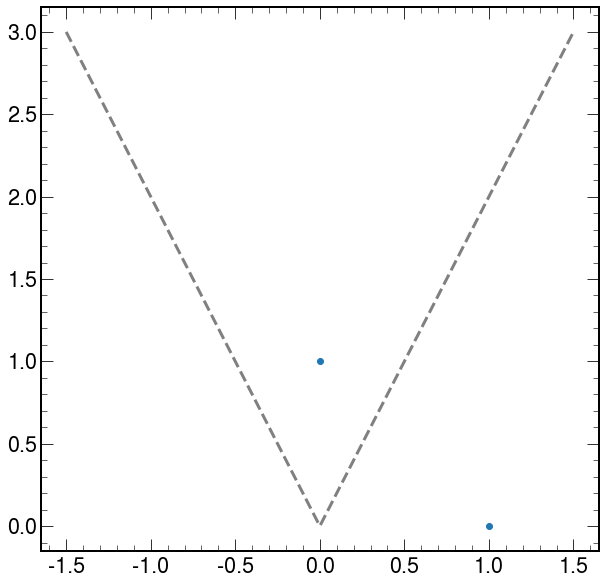

In [161]:
    x_ = np.linspace(-1.5,1.5, 3000)
    plt.plot(x_, np.abs(x_)*2, ls='--', color='grey', linewidth=3)
    plt.scatter([0,1],[1,0])

In [143]:
import os

In [144]:
os.mkdir('DELETEME')

In [145]:
plt.savefig

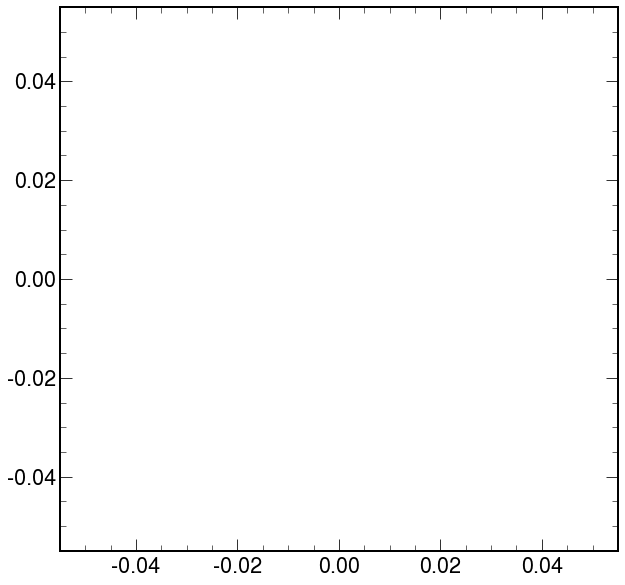

In [142]:
plt.scatter(0, resultBH_SLSQP.likelihood)

In [44]:
print('\tSLSQP\t\tSLSQP+BH')
print('AFB : ', resultSLSQP.params['AFB'])

	SLSQP		SLSQP+BH
AFB :  -0.1


In [74]:
print(listSLSQPBH[1])


Parameter Value        Standard Deviation
AFB       -7.750000e-02 None
FH        1.545320e-01 None
FRAC      0.000000e+00 None
LAMBDA    -4.000000e+00 None
MU        5.400000e+00 None
SIGMA     1.000000e-01 None
Status message         requested number of basinhopping iterations completed successfully
Number of iterations   105
Objective              <symfit.core.objectives.LogLikelihood object at 0x7f0d1f1c5a90>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.SLSQP object at 0x7f0d1f1c5b00>, <symfit.core.minimizers.BasinHopping object at 0x7f0d1f1c5c88>])

Goodness of fit qualifiers:
likelihood             inf
log_likelihood         36878.60546875
objective_value        -36878.60546875

Constraints:
--------------------
Question: 3 - FH >= 0?
Answer:   2.845468006956051

Question: FH >= 0?
Answer:   0.1545319930439487

Question: 0.5*FH - Abs(AFB) >= 0?
Answer:   -0.00023400347803009813




In [47]:
listSLSQP = list()
listSLSQPBH = list()
for i in range(3):
    tiempo_inicial = time.time()
    _resultSLSQP = fitConstraintSLSQP.execute()
    print('SLSQP finished : ', time.time()-tiempo_inicial)
    _resultSLSQP_BH = fitConstraintSLSQP_BH.execute()
    print('SLSQP + BH finished: ', time.time()-tiempo_inicial)
    
    listSLSQP.append(_resultSLSQP)
    listSLSQPBH.append(_resultSLSQP_BH)
    
    print('\tSLSQP\t\tSLSQP+BH')
    print('AFB : ', _resultSLSQP.params['AFB'], _resultSLSQP_BH.params['AFB'] )
    print('FH : ', _resultSLSQP.params['FH'], _resultSLSQP_BH.params['FH'] )
    
    print('\n\n')

/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/fit_results.py:254: RuntimeWarning: overflow encountered in exp
  gof_qualifiers['likelihood'] = np.exp(gof_qualifiers['log_likelihood'])


SLSQP finished :  7.155197620391846


/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/objectives.py:462: RuntimeWarning: invalid value encountered in log
  [np.nansum(np.log(component)) for component in evaluated_func]


SLSQP + BH finished:  146.70809507369995
	SLSQP		SLSQP+BH
AFB :  -0.1 -0.07750000000000001
FH :  0.25 0.14803513378484984



SLSQP finished :  7.11640191078186
SLSQP + BH finished:  142.90130472183228
	SLSQP		SLSQP+BH
AFB :  -0.1 -0.07750000000000445
FH :  0.25 0.1545319930439487



SLSQP finished :  7.084775924682617
SLSQP + BH finished:  146.02348804473877
	SLSQP		SLSQP+BH
AFB :  -0.1 -0.1225
FH :  0.25 0.5





In [50]:
listBH = list()
listBHSLSQP = list()
for i in range(3):
    tiempo_inicial = time.time()
    _resultBH = fitConstraintBH.execute()
    print('BH finished : ', time.time()-tiempo_inicial)
    _resultBH_SLSQP = fitConstraintBH_SLSQP.execute()
    print('BH + SLSQP finished: ', time.time()-tiempo_inicial)
    
    listBH.append(_resultBH)
    listBHSLSQP.append(_resultBH_SLSQP)
    
    print('\tBH\t\tBH+SLSQP')
    print('AFB : ', _resultBH.params['AFB'], _resultBH_SLSQP.params['AFB'] )
    print('FH : ', _resultBH.params['FH'], _resultBH_SLSQP.params['FH'] )
    
    print('\n\n')

/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/objectives.py:462: RuntimeWarning: invalid value encountered in log
  [np.nansum(np.log(component)) for component in evaluated_func]
/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/fit_results.py:254: RuntimeWarning: overflow encountered in exp
  gof_qualifiers['likelihood'] = np.exp(gof_qualifiers['log_likelihood'])


BH finished :  144.33278489112854


/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/objectives.py:462: RuntimeWarning: divide by zero encountered in log
  [np.nansum(np.log(component)) for component in evaluated_func]


BH + SLSQP finished:  290.58209323883057
	BH		BH+SLSQP
AFB :  -0.07750000000000001 -0.07750000000000001
FH :  0.5 0.1549997056252118



BH finished :  160.88176488876343
BH + SLSQP finished:  298.9024267196655
	BH		BH+SLSQP
AFB :  -0.0779054538961214 -0.07750000000000001
FH :  0.15559078890061923 0.5



BH finished :  180.88280177116394
BH + SLSQP finished:  333.9810290336609
	BH		BH+SLSQP
AFB :  -0.07750023570589257 -0.07750000000000001
FH :  0.15499928878756933 0.5





In [79]:
modelSM = modelsSymfit.complete(4, 0, 0.5, params = Params)
_constraintsSM = [
            sympy.LessThan(modelSM.FH, 3),
            sympy.GreaterThan(modelSM.FH, 0),
            sympy.LessThan(sympy.Abs(modelSM.AFB), 0.5*modelSM.FH)
            ]


In [80]:
SMfitConstraintSLSQP = Fit(modelSM.pdf, 
                            cos=np.array(data.cos_l), 
                            mass=np.array(data.Bmass), 
                            objective=LogLikelihood, 
                            constraints=_constraintsSM,
                            #minimizer=[SLSQP, BasinHopping])
                            minimizer=SLSQP)


SMfitConstraintBH_SLSQP = Fit(modelSM.pdf, 
                            cos=np.array(data.cos_l), 
                            mass=np.array(data.Bmass), 
                            objective=LogLikelihood, 
                            constraints=_constraintsSM,
                            minimizer=[BasinHopping, SLSQP])


In [81]:
SMlistSLSQP = list()
SMlistBHSLSQP = list()
for i in range(3):
    tiempo_inicial = time.time()
    _resultSLSQP = SMfitConstraintSLSQP.execute()
    print('SLSQP finished : ', time.time()-tiempo_inicial)
    _resultBH_SLSQP = SMfitConstraintBH_SLSQP.execute()
    print('BH + SLSQP finished: ', time.time()-tiempo_inicial)
    
    SMlistSLSQP.append(_resultSLSQP)
    SMlistBHSLSQP.append(_resultBH_SLSQP)
    
    print('\tSLSQP\t\tBH+SLSQP')
    print('AFB : ', _resultSLSQP.params['AFB'], _resultBH_SLSQP.params['AFB'])
    print('FH : ', _resultSLSQP.params['FH'], _resultBH_SLSQP.params['FH'] )
    const_SLSQP = _resultSLSQP.params['FH'] - np.abs(_resultSLSQP.params['AFB'])
    const_BH_SLSQP = _resultBH_SLSQP.params['FH'] - np.abs(_resultBH_SLSQP.params['AFB'])

    print('0.5*FH - |AFB|' , const_SLSQP , const_BH_SLSQP )
    
    print('\n\n')

SLSQP finished :  16.084205865859985


/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/objectives.py:462: RuntimeWarning: invalid value encountered in log
  [np.nansum(np.log(component)) for component in evaluated_func]


BH + SLSQP finished:  191.68063831329346
	SLSQP		BH+SLSQP
AFB :  -0.225 -0.0004934453004565948
FH :  0.0 0.0
0.5*FH - |AFB| -0.225 -0.0004934453004565948



SLSQP finished :  8.756359338760376
BH + SLSQP finished:  155.45064854621887
	SLSQP		BH+SLSQP
AFB :  -0.225 -0.225
FH :  0.0 0.0
0.5*FH - |AFB| -0.225 -0.225



SLSQP finished :  8.725696802139282
BH + SLSQP finished:  140.4231514930725
	SLSQP		BH+SLSQP
AFB :  -0.225 -0.225
FH :  0.0 0.0
0.5*FH - |AFB| -0.225 -0.225





In [92]:
_afbsBH2 = [0.1]
_fhsBH2 = [0.2]
_correctedFHS2 = [0.2]
_resultsBH2 = []
for i in range(5):
    print(i)
    initial_time = time.time()
    try:
        model = modelsSymfit.complete(4, AFB = _afbsBH2[-1], FH = _fhsBH2[-1], params = Params)
    except Exception as e:
        print(e)
        model = modelsSymfit.complete(4, AFB = _afbsBH2[-1], FH = 2*abs(_afbsBH2[-1]), params = Params)
        _correctedFHS2[-1] = 2*abs(_afbsBH2[-1])
    _constraints = [
            sympy.LessThan(model.FH, 3),
            sympy.GreaterThan(model.FH, 0),
            sympy.LessThan(sympy.Abs(model.AFB), 0.5*model.FH)
            ]
    
    fitConstraintBH_SLSQP = Fit(model.pdf, 
                                cos=np.array(data.cos_l), 
                                mass=np.array(data.Bmass), 
                                objective=LogLikelihood, 
                                constraints=_constraints,
                                minimizer=[BasinHopping, SLSQP])
                                #minimizer=SLSQP)
    
    result = fitConstraintBH_SLSQP.execute()
    _resultsBH2.append(result.params)
    
    _afbsBH2.append(result.params['AFB'])
    _fhsBH2.append(result.params['FH'])
    _correctedFHS2.append(result.params['FH'])
    print(time.time()-initial_time)

0
148.11254382133484
1
The value of `min` should be less than or equal to the value of `max`.
143.10664629936218
2


/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/objectives.py:462: RuntimeWarning: divide by zero encountered in log
  [np.nansum(np.log(component)) for component in evaluated_func]


160.11858415603638
3
141.70880150794983
4
141.83690738677979


In [88]:
_afbsBH1

[0,
 -0.0018413109724485684,
 -0.0011964584645420362,
 -0.0011964584645420362,
 -0.0013026256331053023,
 -0.0024962620093928753]

In [89]:
_fhsBH1

[1,
 0.005116716430245805,
 0.002391934955134562,
 0.0026288914692324914,
 0.005257776546849656,
 0.010515553093699313]

In [90]:
_afbs

[0,
 -0.0007484374317583021,
 -0.0007484374317583021,
 -0.0007484374317583021,
 -0.0007484374317583021,
 -0.0007484374317583021]

In [91]:
_fhs

[1,
 0.0014967110481336398,
 0.0029937497270332084,
 0.0029937497270332084,
 0.0029937497270332084,
 0.0029937497270332084]

In [80]:
_afbs

[0,
 -0.0007484374317583021,
 -0.0007484374317583021,
 -0.0007484374317583021,
 -0.0007484374317583021,
 -0.0007484374317583021]

In [76]:
_fhs

[1,
 0.0014967110481336398,
 0.0029937497270332084,
 0.0029937497270332084,
 0.0029937497270332084,
 0.0029937497270332084]

In [77]:
_results

[OrderedDict([('AFB', -0.0007484374317583021),
              ('FH', 0.0014967110481336398),
              ('FRAC', 0.0),
              ('LAMBDA', -4.0),
              ('MU', 5.398986009615926),
              ('SIGMA', 0.09857040599394803)]),
 OrderedDict([('AFB', -0.0007484374317583021),
              ('FH', 0.0029937497270332084),
              ('FRAC', 0.0),
              ('LAMBDA', -4.0),
              ('MU', 5.4),
              ('SIGMA', 0.1)]),
 OrderedDict([('AFB', -0.0007484374317583021),
              ('FH', 0.0029937497270332084),
              ('FRAC', 0.22730181301102026),
              ('LAMBDA', -3.334),
              ('MU', 5.269),
              ('SIGMA', 0.054)]),
 OrderedDict([('AFB', -0.0007484374317583021),
              ('FH', 0.0029937497270332084),
              ('FRAC', 0.22730181301102026),
              ('LAMBDA', -3.334),
              ('MU', 5.269),
              ('SIGMA', 0.054)]),
 OrderedDict([('AFB', -0.0007484374317583021),
              ('FH', 0.00299374

In [54]:
fitt_Ness.params['AFB']

-0.0021493958616399145

In [41]:
_afb = [0, 0.5, -0.1]
_fh  = [1, 1.5, 0.5]
fitt_BH = list()
for i in range(3):
    ini = time.time()
    
    model = modelsSymfit.complete(4, _afb[i], _fh[i], params = Params)
    _constraints = [
            sympy.LessThan(model.FH, 3),
            sympy.GreaterThan(model.FH, 0),
            sympy.LessThan(sympy.Abs(model.AFB), 0.5*model.FH)
            ]

    
    fitConstraintBH_SLSQP = Fit(model.pdf, 
                          cos=np.array(data.cos_l), 
                          mass=np.array(data.Bmass), 
                          objective=LogLikelihood, constraints=_constraints,
                          minimizer=[BasinHopping, SLSQP])
                          #minimizer=SLSQP)

    print(time.time()-ini)
    fitt_Ness = fitConstraintBH_SLSQP.execute()
    fitt.append(fitt_Ness.params)
    print(time.time()-ini)

3.3582611083984375


/home/horacio/Documents/pycms/lib64/python3.6/site-packages/symfit/core/objectives.py:462: RuntimeWarning: invalid value encountered in log
  [np.nansum(np.log(component)) for component in evaluated_func]


146.36396837234497
3.3960158824920654
154.3784041404724
3.284954309463501
179.61788058280945


In [43]:
fitt_BH = fitt[-3:]

In [50]:
print(fitt_Ness)


Parameter Value        Standard Deviation
AFB       -2.149396e-03 2.204960e-01
FH        3.940588e-05 3.972996e-01
FRAC      1.615726e-03 1.203850e-04
LAMBDA    -3.999965e+00 1.385610e-02
MU        5.281956e+00 2.716335e-03
SIGMA     1.000179e-02 2.165442e-03
Status message         Positive directional derivative for linesearch
Number of iterations   124
Objective              <symfit.core.objectives.LogLikelihood object at 0x7fbcd0a8b9e8>
Minimizer              ChainedMinimizer(minimizers=[<symfit.core.minimizers.BasinHopping object at 0x7fbcd0a8b8d0>, <symfit.core.minimizers.SLSQP object at 0x7fbcd0a8b3c8>])

Goodness of fit qualifiers:
likelihood             inf
log_likelihood         36883.703125
objective_value        -36883.703125

Constraints:
--------------------
Question: 3 - FH >= 0?
Answer:   2.999960594124077

Question: FH >= 0?
Answer:   3.9405875923044105e-05

Question: 0.5*FH - Abs(AFB) >= 0?
Answer:   -0.0021296929236783923




In [44]:
fitt_BH

[OrderedDict([('AFB', -0.0007484374317583021),
              ('FH', 0.0014967110481336398),
              ('FRAC', 0.0),
              ('LAMBDA', -4.0),
              ('MU', 5.398986009615926),
              ('SIGMA', 0.09857040599394803)]),
 OrderedDict([('AFB', 0.275),
              ('FH', 0.5497801217720735),
              ('FRAC', 0.0),
              ('LAMBDA', -4.0),
              ('MU', 5.4),
              ('SIGMA', 0.1)]),
 OrderedDict([('AFB', -0.0021493958616399145),
              ('FH', 3.9405875923044105e-05),
              ('FRAC', 0.001615725722538215),
              ('LAMBDA', -3.9999645948254763),
              ('MU', 5.281955874563895),
              ('SIGMA', 0.010001791175078408)])]

In [45]:
fitt[:-3]

[OrderedDict([('AFB', -0.0007484374317583021),
              ('FH', 0.0014967110481336398),
              ('FRAC', 0.0),
              ('LAMBDA', -4.0),
              ('MU', 5.398986009615926),
              ('SIGMA', 0.09857040599394803)]),
 OrderedDict([('AFB', 0.275),
              ('FH', 0.5497801217720735),
              ('FRAC', 0.0),
              ('LAMBDA', -4.0),
              ('MU', 5.4),
              ('SIGMA', 0.1)]),
 OrderedDict([('AFB', -0.1),
              ('FH', 0.5),
              ('FRAC', 0.22730181301102026),
              ('LAMBDA', -3.334),
              ('MU', 5.269),
              ('SIGMA', 0.054)])]

In [34]:
_constraints = [
            sympy.LessThan(model.FH, 3),
            sympy.GreaterThan(model.FH, 0),
            sympy.LessThan(sympy.Abs(model.AFB), 0.5*model.FH)
            ]

ini = time.time()
fitConstraintBH_SLSQP = Fit(model.pdf, 
                          cos=np.array(data.cos_l), 
                          mass=np.array(data.Bmass), 
                          objective=LogLikelihood, constraints=_constraints,
                          minimizer=[BasinHopping, SLSQP])
                          #minimizer=SLSQP)

print(time.time()-ini)
fitt_Ness = fitConstraintBH_SLSQP.execute()
print(time.time()-ini)

0.00916290283203125
188.8930869102478


In [35]:
fitt_Ness.params

OrderedDict([('AFB', -0.12023769761385397),
             ('FH', 0.4744061512111017),
             ('FRAC', 0.0),
             ('LAMBDA', -4.0),
             ('MU', 5.256806025229823),
             ('SIGMA', 0.1)])

In [28]:
Params['4']

{'free': {'LAMBDA': -3.334, 'MU': 5.269, 'SIGMA': 0.054, 'AFB': '', 'FH': ''},
 'fixed': {'OriginalEffyCoefs': [0.0382,
   0.0009,
   0.0543,
   0.0072,
   0.0151,
   0.0079,
   -0.0525],
  'HoracioEffyCoefs': [1, 0.0388, 0.0199, 0.0488, 0.0259],
  'frac': 0.127,
  'mu': -0.3,
  'sigma': 0.277,
  'sidebandsCoefs': [1, 0.213, 0.0, -0.037]},
 'yield': {'S': 3197, 'B': 10868}}